In [1]:
import csv
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_SEED = 42

In [2]:
# dataset = Path('gestures_dataset_new.csv')
DATASET_CSV = Path('../gestures_dataset.csv')
DATASET_ROOT = Path('../ai_data/vgt-all')

UPLOADED_DATASET_CSV = Path('../uploaded_gestures_dataset.csv')
UPLOADED_DATASET_ROOT = Path('../ai_data/vgt-uploaded')

In [3]:
def handedness_data_from_directory_names(dataset_location: Path):
    handedness_data = {}
    for gesture_folder in os.listdir(dataset_location):
        gesture_name, handedness_string = gesture_folder.split('_')
        handedness_data[gesture_name] = (handedness_string[0] == '1', handedness_string[1] == '1')
    return handedness_data

In [5]:
%load_ext autoreload
%autoreload 2
from sl_ai.gesture_classifier import GestureClassifier
from sl_ai.dataset import GestureDataset

gesture_dataset: GestureDataset = GestureDataset()
# gesture_dataset.scan_videos(dataset_location=DATASET_ROOT, handedness_data=handedness_data_from_directory_names(DATASET_ROOT))
# gesture_dataset.analyze_videos(csv_out_path=DATASET_CSV, overwrite=True)

gesture_dataset.load_from_csv(DATASET_CSV)

# uploaded_dataset: GestureDataset = GestureDataset()
# uploaded_dataset.load_from_csv(UPLOADED_DATASET_CSV)

# gesture_dataset.append_dataset(uploaded_dataset)

gesture_dataset.summary()

classifier: GestureClassifier = GestureClassifier(gesture_dataset=gesture_dataset)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
bowlen(1 -> 1)
bowlen(1 -> 1)
bowlen(1 -> 1)
bowlen(1 -> 1)
bowlen(1 -> 1)
bowlen(1 -> 1)
bowlen(1 -> 1)
bowlen(1 -> 1)
bowlen(1 -> 1)
bowlen(1 -> 1)
bowlen(1 -> 1)
bowlen(1 -> 1)
bowlen(1 -> 1)
bowlen(1 -> 1)
bowlen(1 -> 1)
bowlen(1 -> 1)
bowlen(1 -> 1)
bowlen(1 -> 1)
bowlen(1 -> 

In [6]:
classifier.train(train_size=.6)
classifier.summary()

Training model:
Dataset contain 12 gestures.
Epoch 1/1000
53/53 [==============================] - 1s 4ms/step - loss: 2.5112 - accuracy: 0.0952 - val_loss: 2.3759 - val_accuracy: 0.1667
Epoch 2/1000
53/53 [==============================] - 0s 2ms/step - loss: 2.4532 - accuracy: 0.1429 - val_loss: 2.3350 - val_accuracy: 0.2143
Epoch 3/1000
53/53 [==============================] - 0s 1ms/step - loss: 2.4028 - accuracy: 0.0952 - val_loss: 2.2107 - val_accuracy: 0.2619
Epoch 4/1000
53/53 [==============================] - 0s 2ms/step - loss: 2.2124 - accuracy: 0.1714 - val_loss: 2.1586 - val_accuracy: 0.3571
Epoch 5/1000
53/53 [==============================] - 0s 1ms/step - loss: 2.2371 - accuracy: 0.1333 - val_loss: 2.0692 - val_accuracy: 0.2857
Epoch 6/1000
53/53 [==============================] - 0s 1ms/step - loss: 2.1767 - accuracy: 0.1714 - val_loss: 2.0098 - val_accuracy: 0.3095
Epoch 7/1000
53/53 [==============================] - 0s 1ms/step - loss: 2.0913 - accuracy: 0.1333 - v

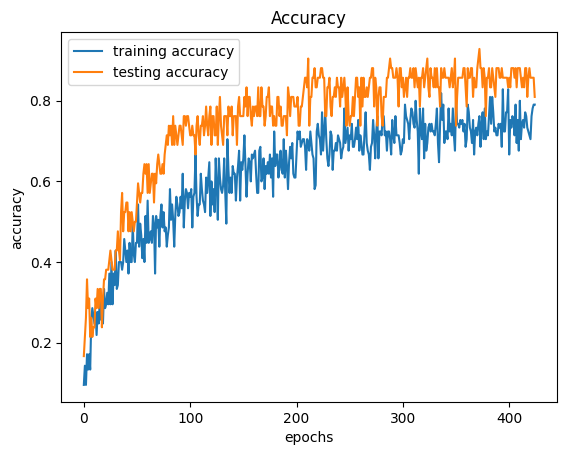

In [7]:
classifier.visualize_accuracy()

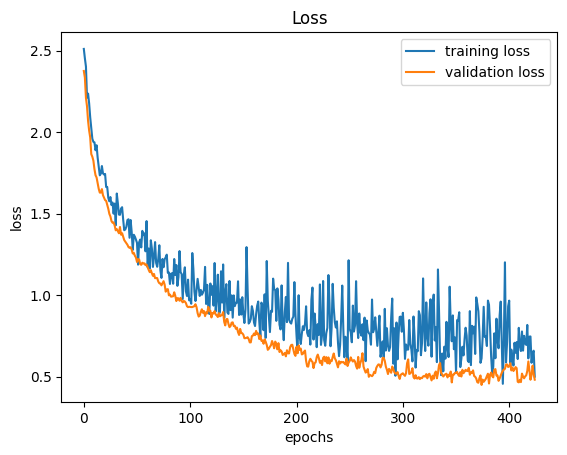

In [8]:
classifier.visualize_loss()

1/1 [==============================] - 0s 62ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       1.00      0.33      0.50         3
           2       0.50      0.50      0.50         2
           3       1.00      0.50      0.67         2
           4       0.67      0.67      0.67         3
           5       1.00      0.50      0.67         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         2
          11       0.67      1.00      0.80         4

    accuracy                           0.79        29
   macro avg       0.85      0.77      0.77        29
weighted avg       0.85      0.79      0.78        29



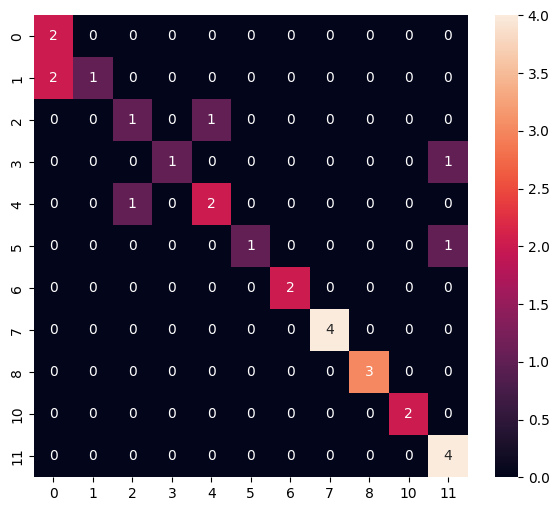

In [9]:
classifier.confusion_matrix()